In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
from pandas import DataFrame

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
torch.__version__

'1.3.1'

In [5]:
USE_CUDA = torch.cuda.is_available()
USE_CUDA

True

In [6]:
device = torch.device('cuda:9')

In [7]:
from utils.data_loaders import get_loaders, get_shape

In [8]:
dataset_name = 'cifar10'

batch_size = 100
train_size = 4000

train_loader, test_loader, test_loader_det = get_loaders(dataset_name, batch_size, train_size)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
input_shape, num_classes = get_shape(dataset_name)
input_shape, num_classes

((3, 32, 32), 10)

In [11]:
from collections import defaultdict

def defaultdict_to_dict(def_a: defaultdict):
    a = dict()
    for k, v in def_a.items():
        if isinstance(v, defaultdict):
            v = defaultdict_to_dict(v)
        a[k] = v
    return a

# Tracking statistics:

In [527]:
import pickle

results_dir = 'results/adam/epoch_wise/'

with open(results_dir+'train_losses.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(train_losses), f)
with open(results_dir+'test_losses.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(test_losses), f)
with open(results_dir+'train_accs.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(train_accs), f)
with open(results_dir+'test_accs.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(test_accs), f)

with open(results_dir+'class_mean_data_mean_mean_logit.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(class_mean_data_mean_mean_logit), f)
with open(results_dir+'class_mean_data_mean_std_logit.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(class_mean_data_mean_std_logit), f)
    

In [53]:
class NestedDefaultDictConstructor():
    def __init__(self, base_type, depth):
        super(NestedDefaultDictConstructor, self).__init__()
        self.depth = depth
        self.base_type = base_type
        
    def _nest_defaultdicts(self, def_dict):
        return defaultdict(lambda: def_dict)
        
    def __call__(self):
        def_dict = self.base_type
        for _ in range(self.depth):
            def_dict = self._nest_defaultdicts(def_dict)
        return def_dict

In [43]:
#defaultdict_constructor = NestedDefaultDictConstructor(float, 8)
defaultdict_constructor = lambda: defaultdict(
    lambda: defaultdict(lambda: defaultdict(
        lambda: defaultdict(lambda: defaultdict(
            lambda: defaultdict(lambda: defaultdict(float)))))))

train_losses = defaultdict_constructor()
test_losses = defaultdict_constructor()

train_accs = defaultdict_constructor()
test_accs = defaultdict_constructor()

In [83]:
num_epochs = 100
eval_every = 1
num_seeds = 5
test_batch_count = 10

bias = False

base_widths = [128]
optimization_modes = ['sgd_momentum', 'adam']
scaling_modes = ['default', 'preserve_logit_mean']
log_width_factors = [-2, -1, 0, 1, 2]
log_lr_factors = [0]

In [102]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
from utils.init_model import scale_hyperparams, _count_layers, _test_gradient_normalization
from utils.models import ConvLarge

from utils.train_and_eval import perform_epoch

In [99]:
_count_layers(model.hidden_layers)

5

In [100]:
model

ConvLarge(
  (input_layer): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (hidden_layers): Sequential(
    (0): LeakyReLU(negative_slope=0.1)
    (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (2): LeakyReLU(negative_slope=0.1)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.0, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): LeakyReLU(negative_slope=0.1)
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): LeakyReLU(negative_slope=0.1)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout2d(p=0.0, inplace=False)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (12): LeakyReLU(negative_slope=0.1)
    (13): AvgPool2d(kernel_size=(8, 8), stride=(8, 8), padding=0)
 

In [19]:
from itertools import chain

In [20]:
class SGDMomentum(optim.SGD):
    def __init__(self, params, lr, momentum=0.9, **kwargs):
        super(SGDMomentum, self).__init__(params, lr=lr, momentum=momentum, **kwargs)

In [115]:
for base_width in base_widths:
    for optimization_mode in optimization_modes[:1]:
        for scaling_mode in scaling_modes[1:]:
            for log_width_factor in log_width_factors:
                if scaling_mode != 'default' and log_width_factor == 0:
                    continue
                for log_lr_factor in log_lr_factors:
                    print('base width = {}'.format(base_width))
                    print('optimization mode = {}'.format(optimization_mode))
                    print('scaling mode: {}'.format(scaling_mode))
                    print('log width factor = {}'.format(log_width_factor))
                    print('log lr factor = {}'.format(log_lr_factor))

                    if optimization_mode == 'sgd':
                        optimizer_class = optim.SGD
                        base_lr = 1e-2
                    elif optimization_mode == 'sgd_momentum':
                        optimizer_class = SGDMomentum
                        base_lr = 1e-2
                    elif optimization_mode == 'rmsprop':
                        optimizer_class = optim.RMSprop
                        base_lr = 3e-4
                    elif optimization_mode == 'adam':
                        optimizer_class = optim.Adam
                        base_lr = 3e-4
                    else:
                        raise ValueError

                    if log_width_factor >= 0:
                        width = base_width * (2 ** log_width_factor)
                    else:
                        width = base_width // (2 ** (-log_width_factor))

                    mod_base_lr = base_lr * (2 ** log_lr_factor)

                    for seed in range(num_seeds):
                        torch.manual_seed(seed)
                        #np.random.seed(seed)

                        model = ConvLarge(input_shape, num_classes, init_num_kernels=width, use_bn=False, 
                                          hidden_bias=bias, output_bias=bias, dropout_rate=0.0).to(device)

                        optimizer = optimizer_class(
                            [
                                {'params': model.input_layer.parameters()},
                                {'params': model.hidden_layers.parameters()},
                                {'params': model.output_layer.parameters()}
                            ], lr=mod_base_lr
                        )

                        scale_hyperparams(
                            model.input_layer, model.hidden_layers, model.output_layer, 
                            optimizer=optimizer, width_factor=2**log_width_factor, scaling_mode=scaling_mode
                        )

                        for epoch in range(num_epochs):
                            model.train()
                            train_loss, train_acc = perform_epoch(model, train_loader, optimizer=optimizer, device=device)

                            if (epoch+1) % eval_every == 0:
                                train_losses[base_width][optimization_mode][scaling_mode][
                                    log_width_factor
                                ][log_lr_factor][seed][epoch] = train_loss
                                train_accs[base_width][optimization_mode][scaling_mode][
                                    log_width_factor
                                ][log_lr_factor][seed][epoch] = train_acc

                                model.eval()
                                test_loss, test_acc = perform_epoch(model, test_loader, device=device, max_batch_count=test_batch_count)
                                test_losses[base_width][optimization_mode][scaling_mode][
                                    log_width_factor
                                ][log_lr_factor][seed][epoch] = test_loss
                                test_accs[base_width][optimization_mode][scaling_mode][
                                    log_width_factor
                                ][log_lr_factor][seed][epoch] = test_acc

                            if epoch == num_epochs - 1:
                                print('seed = {}'.format(seed))
                                print('train loss = {:.4f}, train acc = {:.2f}'.format(train_loss, train_acc*100))
                                print('test loss = {:.4f}, test acc = {:.2f}'.format(test_loss, test_acc*100))            
                                print()


base width = 128
optimization mode = sgd_momentum
scaling mode: preserve_logit_mean
log width factor = -2
log lr factor = 0
seed = 0
train loss = 0.0024, train acc = 100.00
test loss = 3.3550, test acc = 58.40

seed = 1
train loss = 0.0034, train acc = 100.00
test loss = 2.6185, test acc = 63.20

seed = 2
train loss = 0.0552, train acc = 98.62
test loss = 2.7918, test acc = 57.20

seed = 3
train loss = 0.0060, train acc = 100.00
test loss = 2.3922, test acc = 61.80

seed = 4
train loss = 0.0013, train acc = 100.00
test loss = 2.7889, test acc = 61.40

base width = 128
optimization mode = sgd_momentum
scaling mode: preserve_logit_mean
log width factor = -1
log lr factor = 0
seed = 0
train loss = 0.0759, train acc = 98.12
test loss = 1.9910, test acc = 63.10

seed = 1
train loss = 0.0756, train acc = 98.00
test loss = 1.9983, test acc = 63.20

seed = 2
train loss = 0.0522, train acc = 98.90
test loss = 1.8548, test acc = 65.20

seed = 3
train loss = 0.3390, train acc = 88.15
test loss = 

In [120]:
for layer in chain(model.hidden_layers, [model.output_layer]):
    print(layer)

LeakyReLU(negative_slope=0.1)
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
LeakyReLU(negative_slope=0.1)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Dropout2d(p=0.0, inplace=False)
Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
LeakyReLU(negative_slope=0.1)
Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
LeakyReLU(negative_slope=0.1)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Dropout2d(p=0.0, inplace=False)
Conv2d(1024, 2048, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
LeakyReLU(negative_slope=0.1)
AvgPool2d(kernel_size=(8, 8), stride=(8, 8), padding=0)
Flatten()
Linear(in_features=2048, out_features=1024, bias=False)
LeakyReLU(negative_slope=0.1)
Linear(in_features=1024, out_features=10, bias=False)


In [211]:
import pickle

results_dir = 'results/per_epoch/'

with open(results_dir+'train_losses.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(train_losses), f)
with open(results_dir+'test_losses.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(test_losses), f)
with open(results_dir+'train_accs.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(train_accs), f)
with open(results_dir+'test_accs.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(test_accs), f)

with open(results_dir+'class_mean_data_mean_mean_logit.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(class_mean_data_mean_mean_logit), f)
with open(results_dir+'class_mean_data_mean_std_logit.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(class_mean_data_mean_std_logit), f)
    

In [57]:
plt.rcParams.update({'font.size': 16})

In [108]:
used_scaling_modes = ['default', 'preserve_logit_mean']
used_optimization_modes = ['sgd_momentum', 'adam']

legend_list = ['reference', 'default scaling', 'preserve logit distrs']

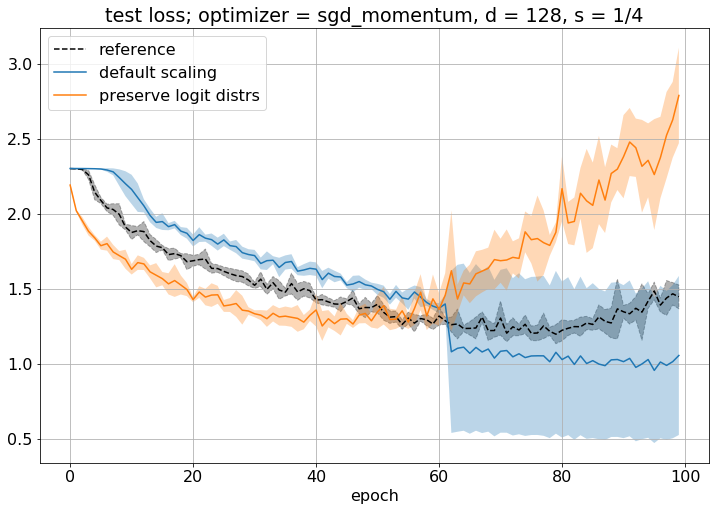

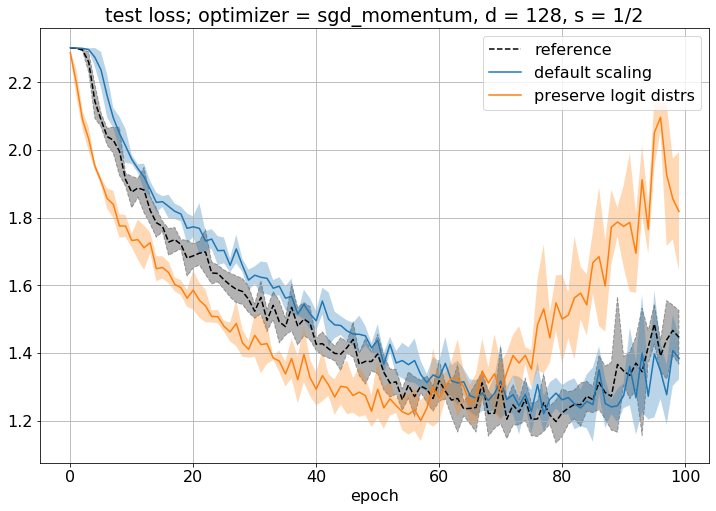

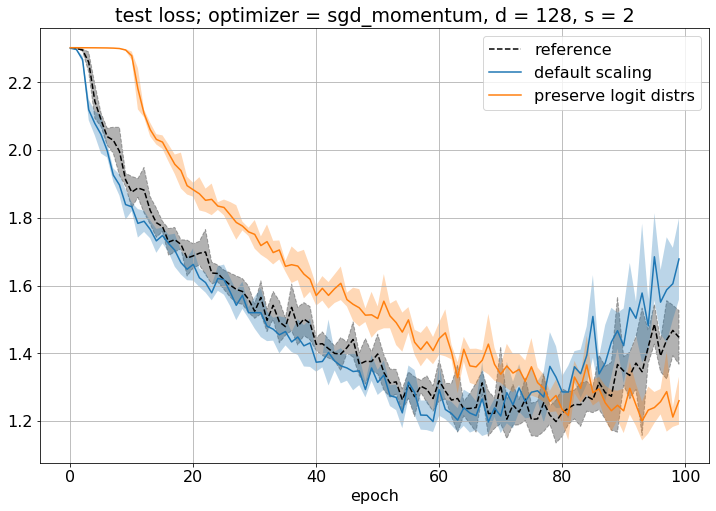

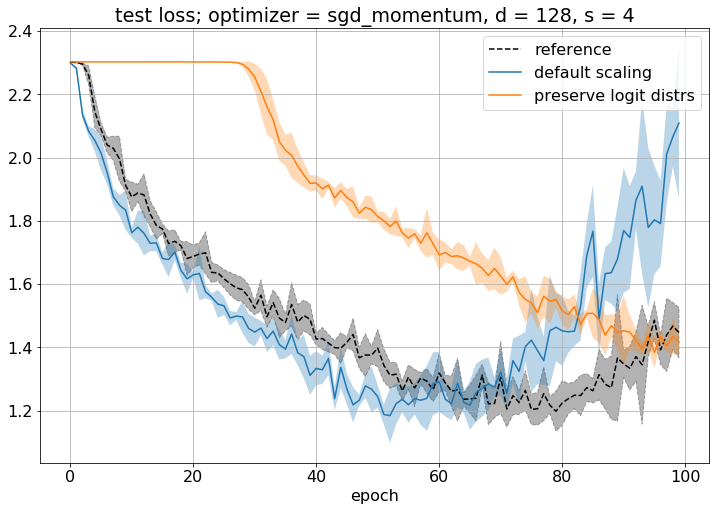

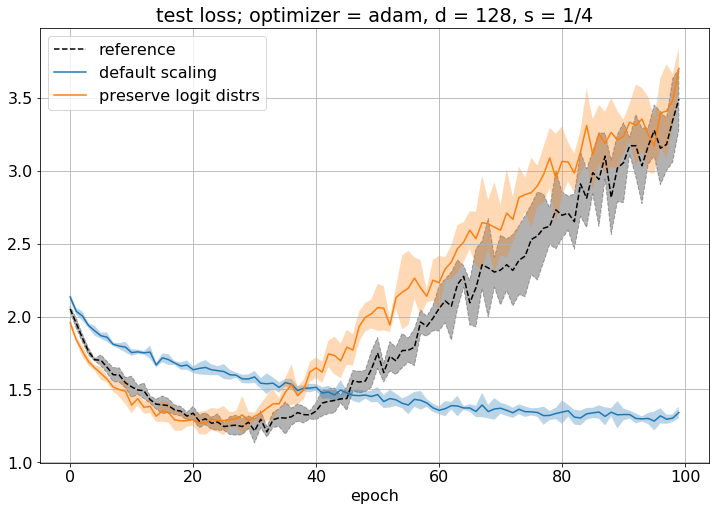

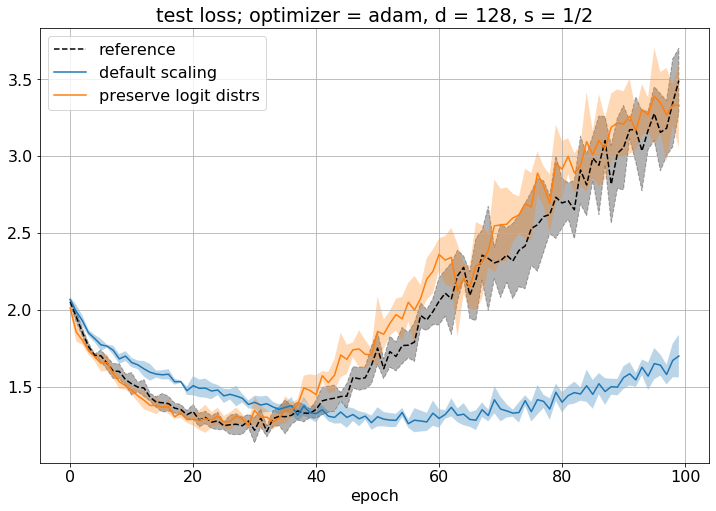

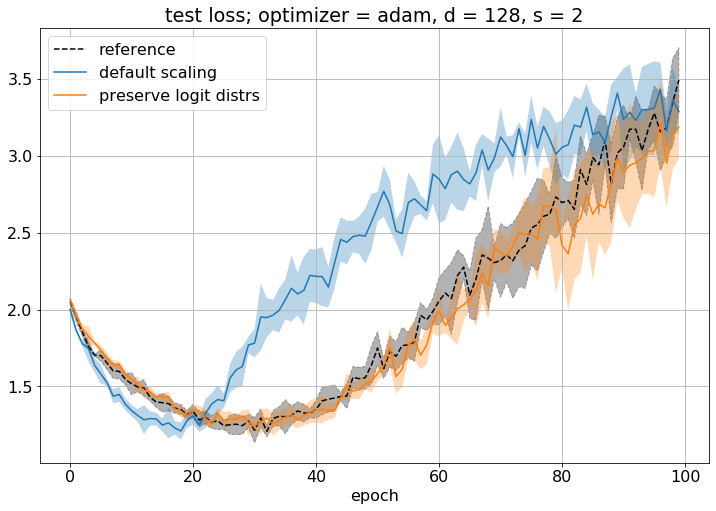

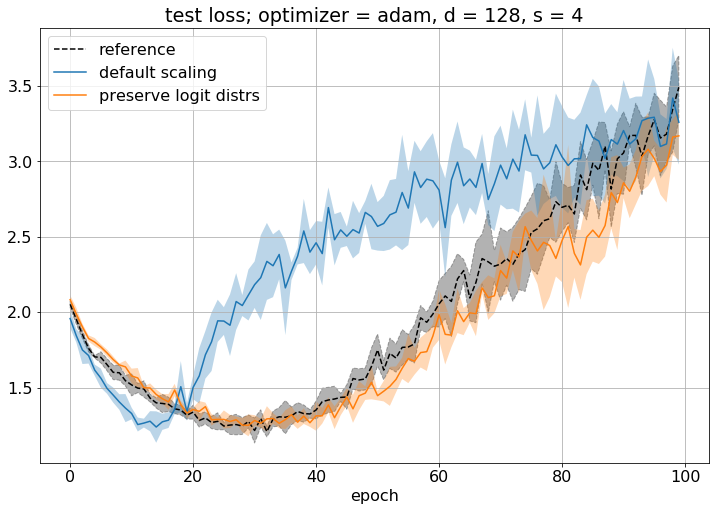

In [116]:
def draw_curve(base_width, optimization_mode, scaling_mode, log_width_factor, log_lr_dactor, **kwargs):
    data = [[
        test_losses[base_width][optimization_mode][scaling_mode][log_width_factor][log_lr_factor][seed][epoch]
        for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
    ] for seed in range(num_seeds)]
    data = np.array(data)
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    plt.plot(np.arange(num_epochs), data_mean, **kwargs)
    plt.fill_between(
        np.arange(num_epochs),
        data_mean - data_std, data_mean + data_std,
        alpha=0.3, **kwargs
    )

for base_width in base_widths:
    for optimization_mode in used_optimization_modes:
        for log_lr_factor in log_lr_factors:
            for log_width_factor in log_width_factors:
                if log_width_factor == 0:
                    continue
            
                _ = plt.figure(figsize=(12,8))
                draw_curve(base_width, optimization_mode, 'default', 0, log_lr_factor, color='black', linestyle='dashed')
            
                for scaling_mode in used_scaling_modes:
                    draw_curve(base_width, optimization_mode, scaling_mode, log_width_factor, log_lr_factor)

                if log_width_factor >= 0:
                    plt.title('test loss; optimizer = {}, d = {}, s = {}'.format(optimization_mode, base_width, int(2**(log_width_factor))))
                else:
                    plt.title('test loss; optimizer = {}, d = {}, s = 1/{}'.format(optimization_mode, base_width, int(2**(-log_width_factor))))
                plt.legend(legend_list)
                #plt.ylim((0.3,0.7))
                plt.xlabel('epoch')
                plt.grid(True)
                plt.show()

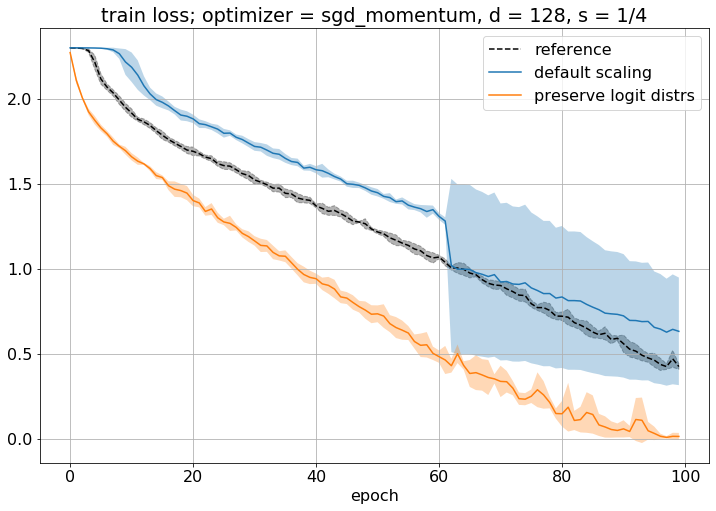

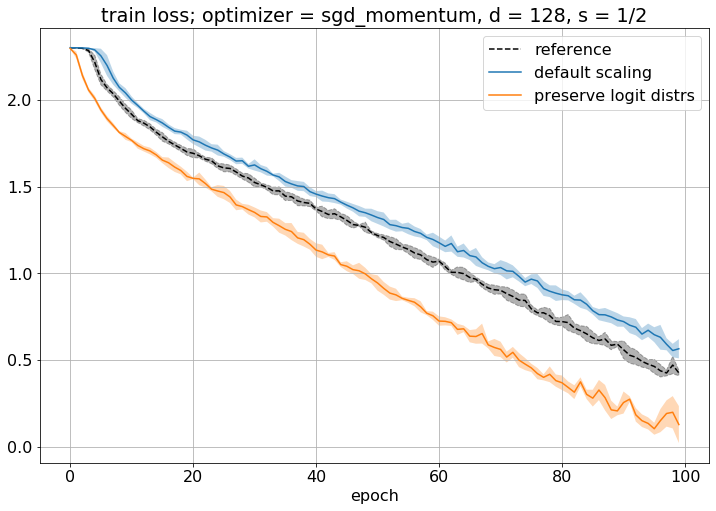

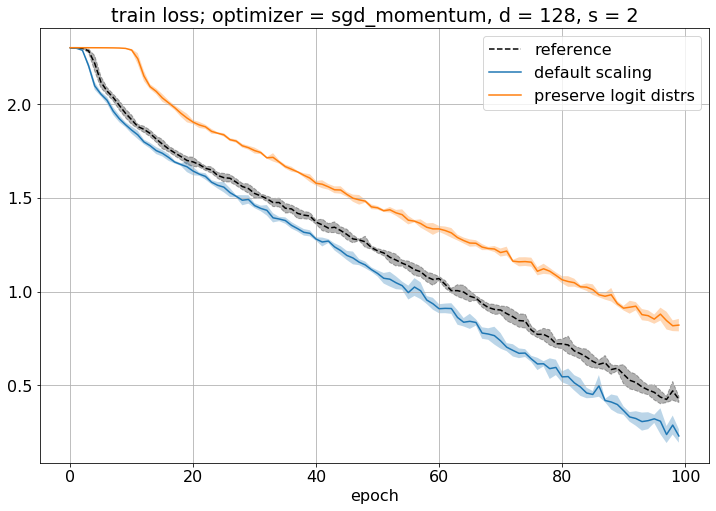

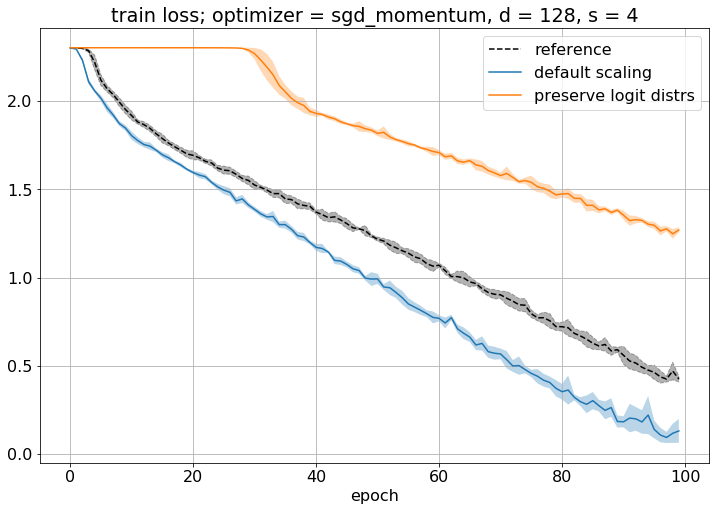

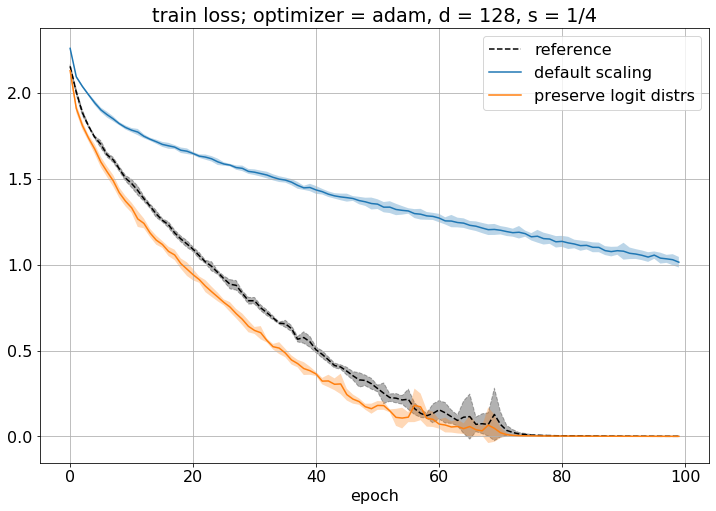

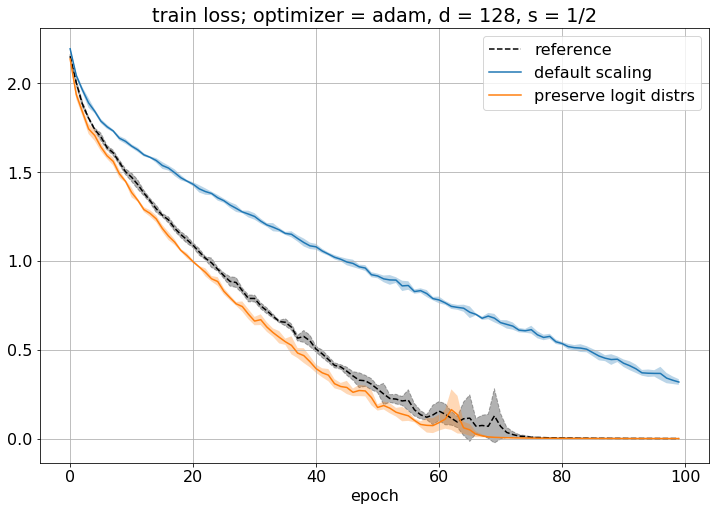

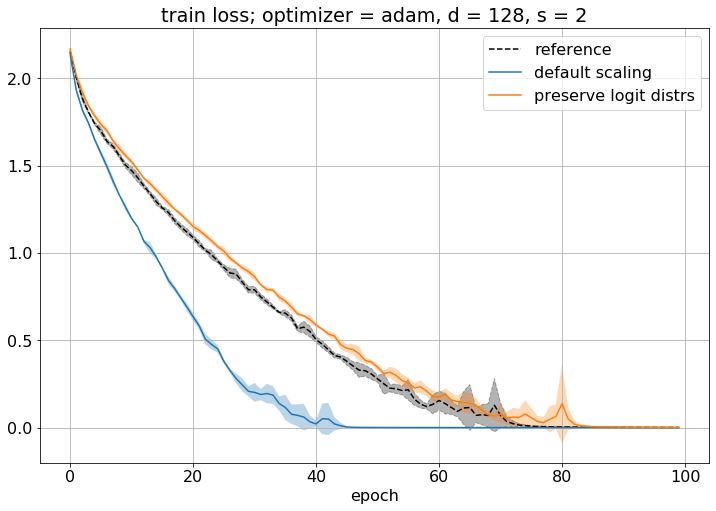

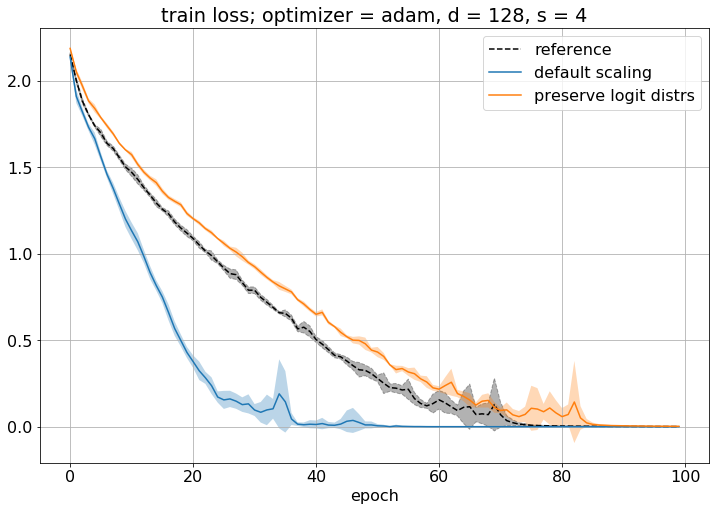

In [117]:
def draw_curve(base_width, optimization_mode, scaling_mode, log_width_factor, log_lr_dactor, **kwargs):
    data = [[
        train_losses[base_width][optimization_mode][scaling_mode][log_width_factor][log_lr_factor][seed][epoch]
        for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
    ] for seed in range(num_seeds)]
    data = np.array(data)
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    plt.plot(np.arange(num_epochs), data_mean, **kwargs)
    plt.fill_between(
        np.arange(num_epochs),
        data_mean - data_std, data_mean + data_std,
        alpha=0.3, **kwargs
    )

for base_width in base_widths:
    for optimization_mode in used_optimization_modes:
        for log_lr_factor in log_lr_factors:
            for log_width_factor in log_width_factors:
                if log_width_factor == 0:
                    continue
            
                _ = plt.figure(figsize=(12,8))
                draw_curve(base_width, optimization_mode, 'default', 0, log_lr_factor, color='black', linestyle='dashed')
            
                for scaling_mode in used_scaling_modes:
                    draw_curve(base_width, optimization_mode, scaling_mode, log_width_factor, log_lr_factor)

                if log_width_factor >= 0:
                    plt.title('train loss; optimizer = {}, d = {}, s = {}'.format(optimization_mode, base_width, int(2**(log_width_factor))))
                else:
                    plt.title('train loss; optimizer = {}, d = {}, s = 1/{}'.format(optimization_mode, base_width, int(2**(-log_width_factor))))
                plt.legend(legend_list)
                #plt.ylim((0.,0.5 if optimization_mode == 'sgd' else 0.2))
                plt.grid(True)
                plt.xlabel('epoch')
                plt.show()

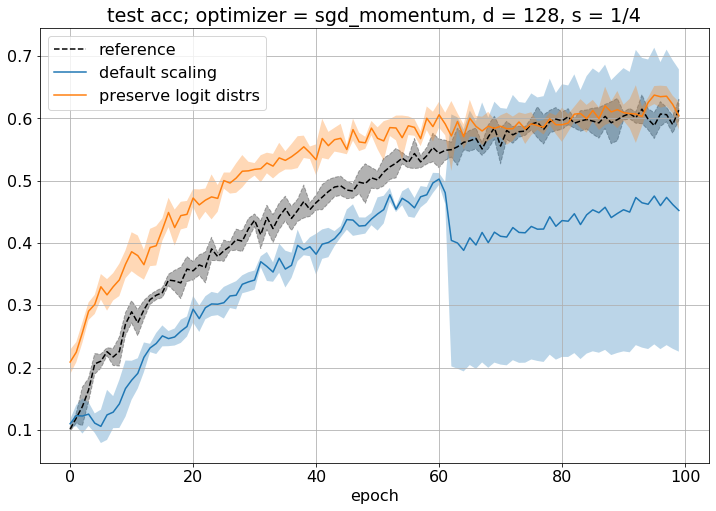

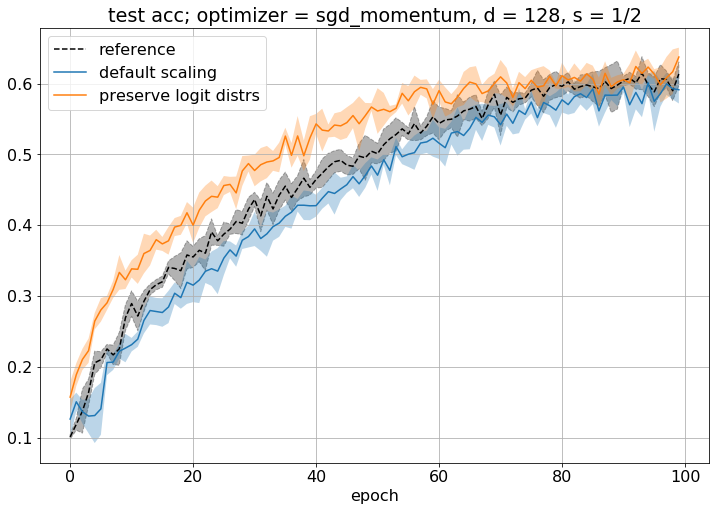

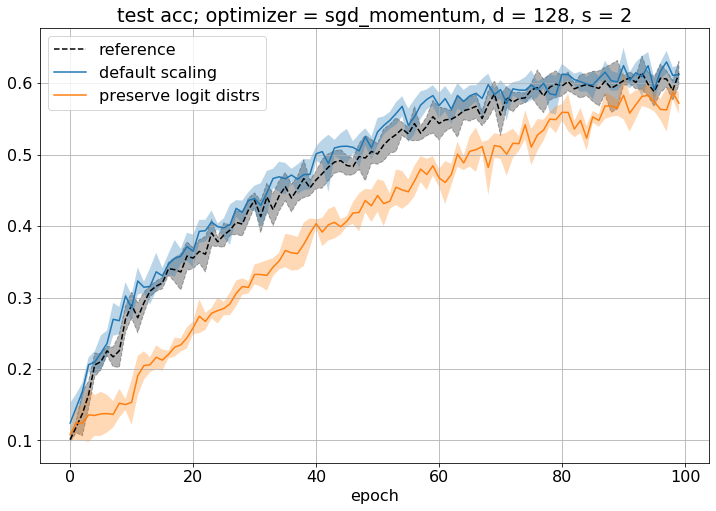

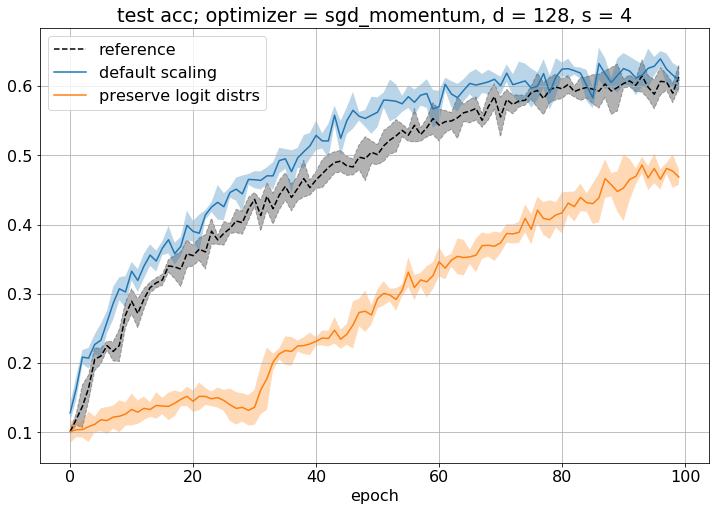

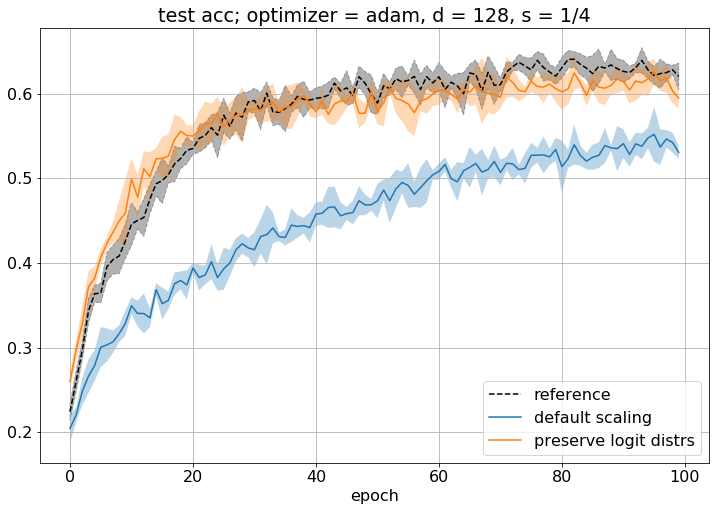

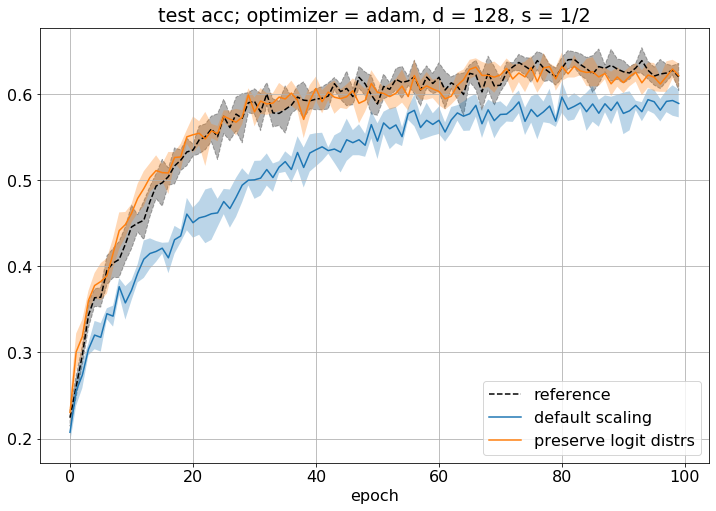

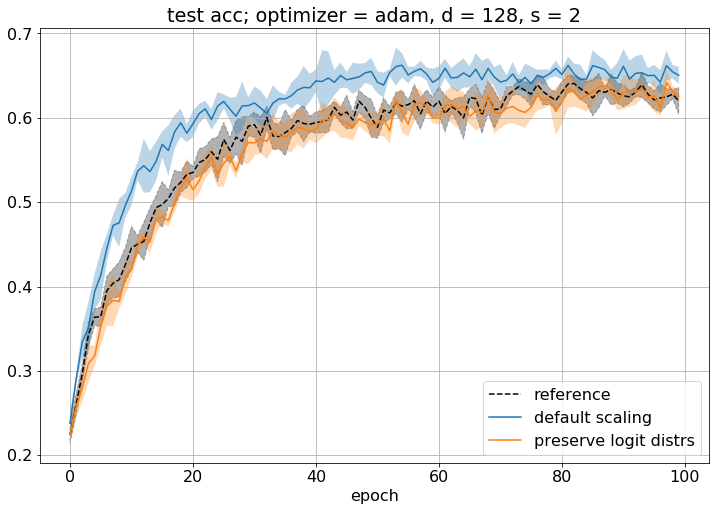

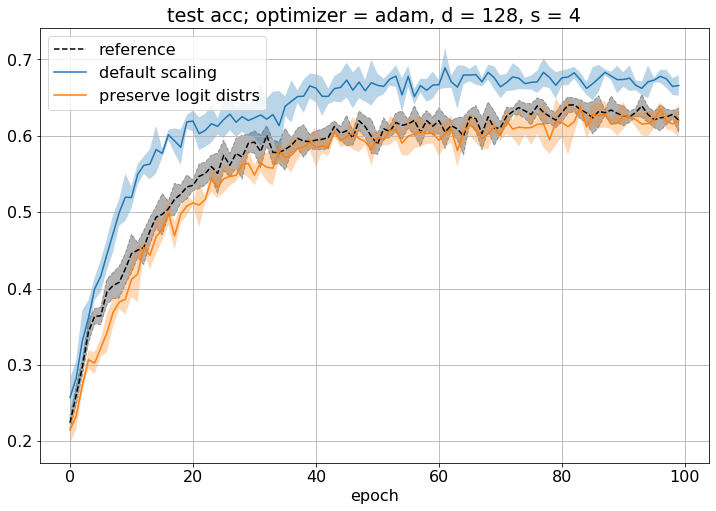

In [118]:
def draw_curve(base_width, optimization_mode, scaling_mode, log_width_factor, log_lr_dactor, **kwargs):
    data = [[
        test_accs[base_width][optimization_mode][scaling_mode][log_width_factor][log_lr_factor][seed][epoch]
        for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
    ] for seed in range(num_seeds)]
    data = np.array(data)
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    plt.plot(np.arange(num_epochs), data_mean, **kwargs)
    plt.fill_between(
        np.arange(num_epochs),
        data_mean - data_std, data_mean + data_std,
        alpha=0.3, **kwargs
    )

for base_width in base_widths:
    for optimization_mode in used_optimization_modes:
        for log_lr_factor in log_lr_factors:
            for log_width_factor in log_width_factors:
                if log_width_factor == 0:
                    continue
            
                _ = plt.figure(figsize=(12,8))
                draw_curve(base_width, optimization_mode, 'default', 0, log_lr_factor, color='black', linestyle='dashed')
            
                for scaling_mode in used_scaling_modes:
                    draw_curve(base_width, optimization_mode, scaling_mode, log_width_factor, log_lr_factor)

                if log_width_factor >= 0:
                    plt.title('test acc; optimizer = {}, d = {}, s = {}'.format(optimization_mode, base_width, int(2**(log_width_factor))))
                else:
                    plt.title('test acc; optimizer = {}, d = {}, s = 1/{}'.format(optimization_mode, base_width, int(2**(-log_width_factor))))
                plt.legend(legend_list)
                #plt.ylim((0.84,0.94))
                plt.grid(True)
                plt.xlabel('epoch')
                plt.show()

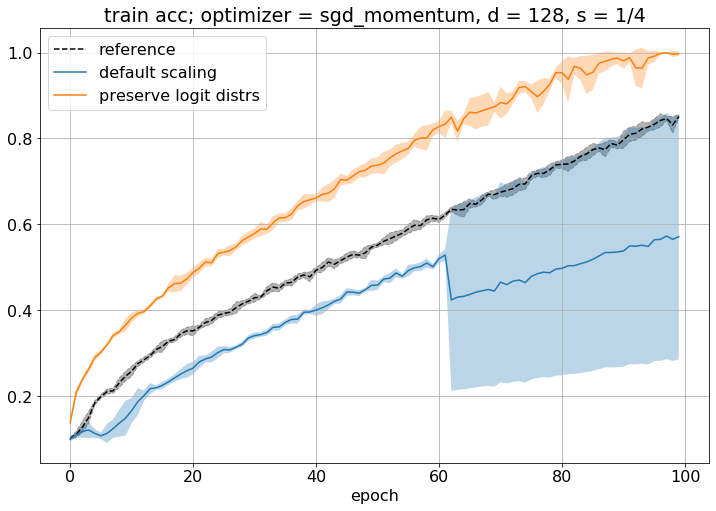

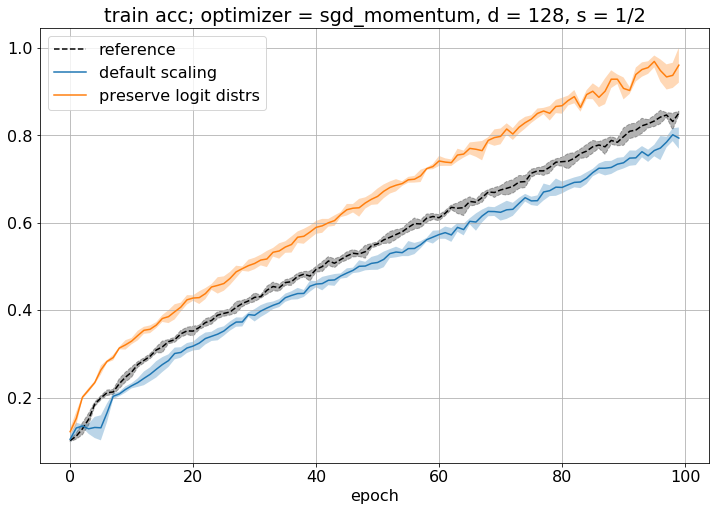

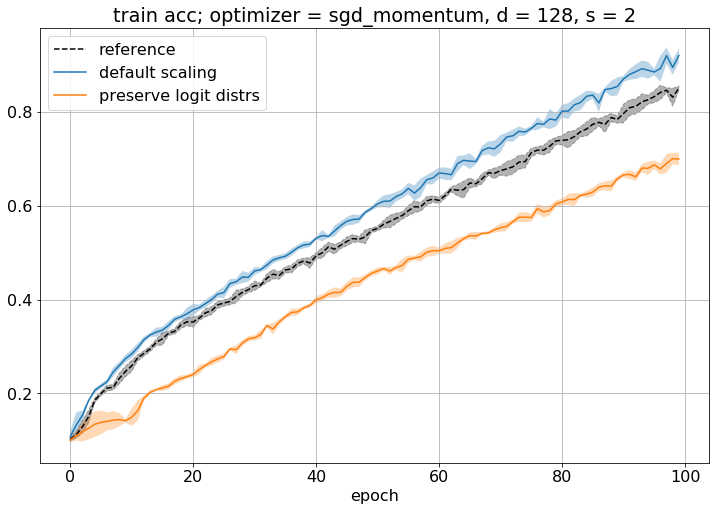

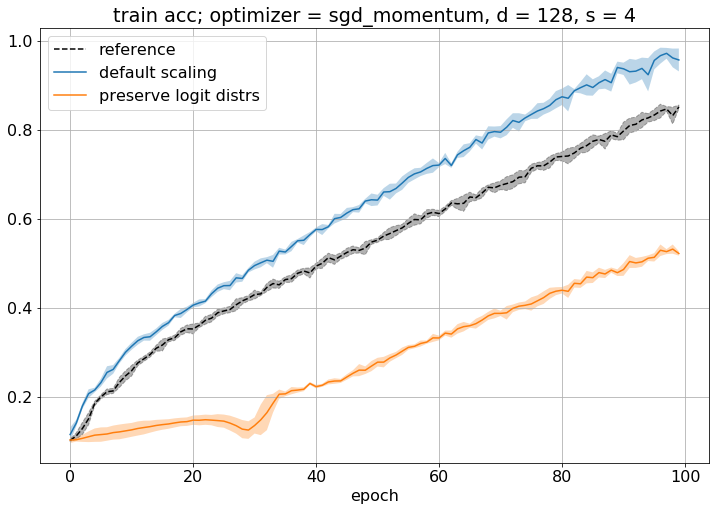

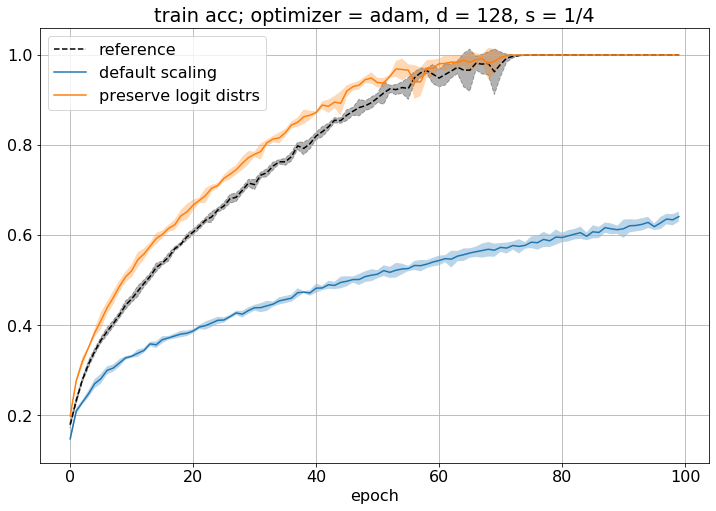

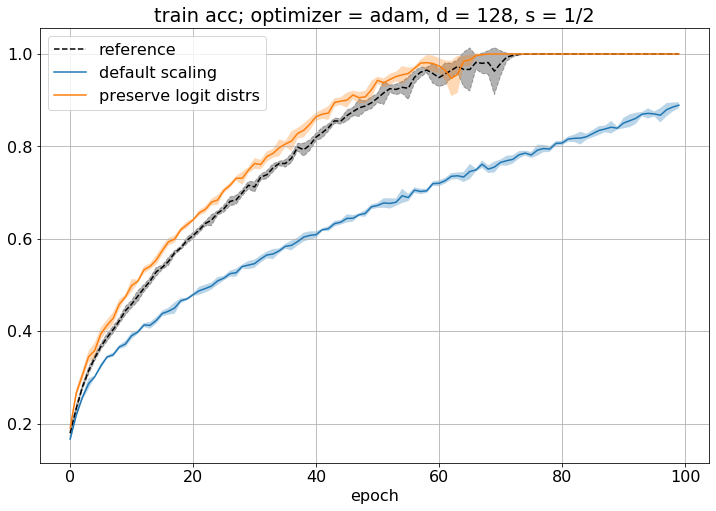

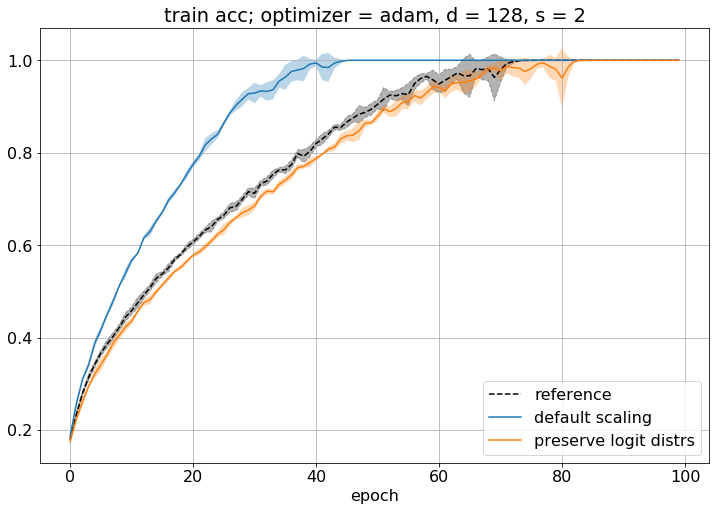

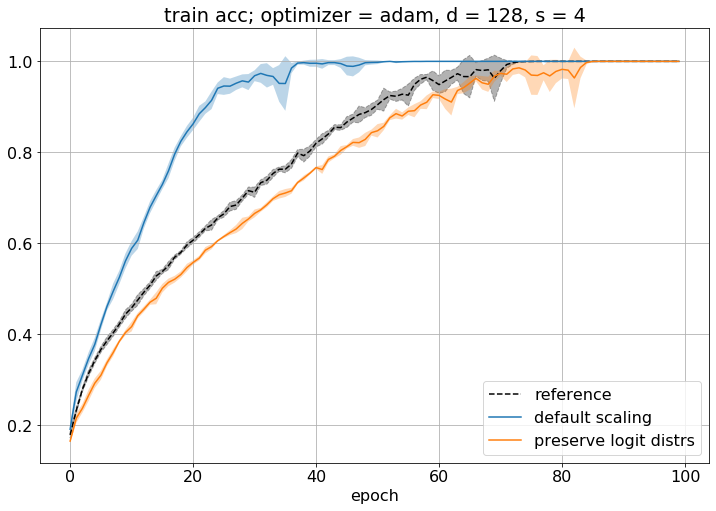

In [119]:
def draw_curve(base_width, optimization_mode, scaling_mode, log_width_factor, log_lr_dactor, **kwargs):
    data = [[
        train_accs[base_width][optimization_mode][scaling_mode][log_width_factor][log_lr_factor][seed][epoch]
        for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
    ] for seed in range(num_seeds)]
    data = np.array(data)
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    plt.plot(np.arange(num_epochs), data_mean, **kwargs)
    plt.fill_between(
        np.arange(num_epochs),
        data_mean - data_std, data_mean + data_std,
        alpha=0.3, **kwargs
    )

for base_width in base_widths:
    for optimization_mode in used_optimization_modes:
        for log_lr_factor in log_lr_factors:
            for log_width_factor in log_width_factors:
                if log_width_factor == 0:
                    continue
            
                _ = plt.figure(figsize=(12,8))
                draw_curve(base_width, optimization_mode, 'default', 0, log_lr_factor, color='black', linestyle='dashed')
            
                for scaling_mode in used_scaling_modes:
                    draw_curve(base_width, optimization_mode, scaling_mode, log_width_factor, log_lr_factor)

                if log_width_factor >= 0:
                    plt.title('train acc; optimizer = {}, d = {}, s = {}'.format(optimization_mode, base_width, int(2**(log_width_factor))))
                else:
                    plt.title('train acc; optimizer = {}, d = {}, s = 1/{}'.format(optimization_mode, base_width, int(2**(-log_width_factor))))
                plt.legend(legend_list)
                #plt.ylim((0.9,1.1))
                plt.grid(True)
                plt.xlabel('epoch')
                plt.show()

In [121]:
#defaultdict_constructor = NestedDefaultDictConstructor(float, 7)
defaultdict_constructor = lambda: defaultdict(
    lambda: defaultdict(lambda: defaultdict(
        lambda: defaultdict(lambda: defaultdict(
            lambda: defaultdict(float))))))

final_train_losses = defaultdict_constructor()
final_test_losses = defaultdict_constructor()

final_train_accs = defaultdict_constructor()
final_test_accs = defaultdict_constructor()

In [132]:
num_epochs = 100
num_seeds = 5

bias = False

base_widths = [128]
optimization_modes = ['adam']
scaling_modes = ['default', 'preserve_logit_mean']
log_width_factors = [-4, -2, 0]
log_lr_factors = [-3, -2, -1, 0, 1, 2, 3]

In [128]:
from utils.models import ConvLarge

In [135]:
base_lr_not_normalized = 1e-2
base_lr_normalized = 3e-4

In [ ]:
for base_width in base_widths:
    for optimization_mode in optimization_modes:
        for scaling_mode in scaling_modes:
            for log_width_factor in log_width_factors[::-1]:
                if scaling_mode != 'default' and log_width_factor == 0:
                    continue
                for log_lr_factor in log_lr_factors:
                    print('base width = {}'.format(base_width))
                    print('optimization mode = {}'.format(optimization_mode))
                    print('scaling mode: {}'.format(scaling_mode))
                    print('log width factor = {}'.format(log_width_factor))
                    print('log lr factor = {}'.format(log_lr_factor))

                    if optimization_mode == 'sgd':
                        optimizer_class = optim.SGD
                        base_lr = base_lr_not_normalized
                    elif optimization_mode == 'sgd_momentum':
                        optimizer_class = SGDMomentum
                        base_lr = base_lr_not_normalized
                    elif optimization_mode == 'rmsprop':
                        optimizer_class = optim.RMSprop
                        base_lr = base_lr_normalized
                    elif optimization_mode == 'adam':
                        optimizer_class = optim.Adam
                        base_lr = base_lr_normalized
                    else:
                        raise ValueError

                    if log_width_factor >= 0:
                        width = base_width * (2 ** log_width_factor)
                    else:
                        width = base_width // (2 ** (-log_width_factor))

                    mod_base_lr = base_lr * (2 ** log_lr_factor)

                    for seed in range(num_seeds):
                        torch.manual_seed(seed)
                        #np.random.seed(seed)

                        model = ConvLarge(input_shape, num_classes, init_num_kernels=width, use_bn=False, 
                                          hidden_bias=bias, output_bias=bias, dropout_rate=0.0).to(device)

                        optimizer = optimizer_class(
                            [
                                {'params': model.input_layer.parameters()},
                                {'params': model.hidden_layers.parameters()},
                                {'params': model.output_layer.parameters()}
                            ], lr=mod_base_lr
                        )

                        scale_hyperparams(
                            model.input_layer, model.hidden_layers, model.output_layer, 
                            optimizer=optimizer, width_factor=2**log_width_factor, scaling_mode=scaling_mode
                        )

                        for epoch in range(num_epochs):
                            model.train()
                            train_loss, train_acc = perform_epoch(model, train_loader, optimizer=optimizer, device=device)

                        final_train_losses[base_width][optimization_mode][scaling_mode][
                            log_width_factor
                        ][log_lr_factor][seed] = train_loss
                        final_train_accs[base_width][optimization_mode][scaling_mode][
                            log_width_factor
                        ][log_lr_factor][seed] = train_acc

                        model.eval()
                        test_loss, test_acc = perform_epoch(model, test_loader, device=device)
                        final_test_losses[base_width][optimization_mode][scaling_mode][
                            log_width_factor
                        ][log_lr_factor][seed] = test_loss
                        final_test_accs[base_width][optimization_mode][scaling_mode][
                            log_width_factor
                        ][log_lr_factor][seed] = test_acc

                        print('seed = {}'.format(seed))
                        print('train loss = {:.4f}, train acc = {:.2f}'.format(train_loss, train_acc*100))
                        print('test loss = {:.4f}, test acc = {:.2f}'.format(test_loss, test_acc*100))            
                        print()


base width = 128
optimization mode = adam
scaling mode: default
log width factor = 0
log lr factor = -3
seed = 0
train loss = 1.3100, train acc = 53.00
test loss = 1.4172, test acc = 48.56

seed = 1
train loss = 1.2927, train acc = 54.12
test loss = 1.4420, test acc = 47.25

seed = 2
train loss = 1.2689, train acc = 54.17
test loss = 1.4089, test acc = 49.22

seed = 3
train loss = 1.2847, train acc = 54.17
test loss = 1.4204, test acc = 48.31

seed = 4
train loss = 1.3027, train acc = 53.12
test loss = 1.4142, test acc = 48.78

base width = 128
optimization mode = adam
scaling mode: default
log width factor = 0
log lr factor = -2
seed = 0
train loss = 0.9044, train acc = 67.60
test loss = 1.2867, test acc = 55.64



In [526]:
import pickle

results_dir = 'results/final/'

with open(results_dir+'final_train_losses.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(final_train_losses), f)
with open(results_dir+'final_test_losses.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(final_test_losses), f)
with open(results_dir+'final_train_accs.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(final_train_accs), f)
with open(results_dir+'final_test_accs.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(final_test_accs), f)
    

In [ ]:
plt.rcParams.update({'font.size': 16})

In [ ]:
used_scaling_modes = ['default', 'preserve_logit_mean']
used_optimization_modes = ['adam']

legend_list = ['reference', 'default scaling', 'preserve logit distrs']

In [ ]:
def draw_curve(base_width, optimization_mode, adaptivity_mode, scaling_mode, log_width_factor, **kwargs):
    data = [[
        final_test_accs[base_width][optimization_mode][scaling_mode][log_width_factor][log_lr_factor][seed]
        for log_lr_factor in log_lr_factors
    ] for seed in range(num_seeds)]
    data = np.array(data)
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    plt.plot(log_lr_factors, data_mean, **kwargs)
    plt.fill_between(
        log_lr_factors,
        data_mean - data_std, data_mean + data_std,
        alpha=0.3, **kwargs
    )

for base_width in base_widths:
    for optimization_mode in used_optimization_modes:
        for log_width_factor in log_width_factors[:-1]:
            _ = plt.figure(figsize=(12,8))

            draw_curve(base_width, optimization_mode, 'default', 0, color='black', linestyle='dashed')

            for scaling_mode, c in zip(used_scaling_modes, range(len(scaling_modes))):
                draw_curve(base_width, optimization_mode, scaling_mode, log_width_factor, color=cmap(c))

            plt.title('final test acc; optimizer = {}, d = {}, s = 1/{}'.format(optimization_mode, base_width, int(2**(-log_width_factor))))
            plt.legend(legend_list)
            if optimization_mode in ['sgd', 'sgd_momentum']:
                base_lr = base_lr_not_normalized
            elif optimization_mode in ['rmsprop', 'adam']:
                base_lr = base_lr_normalized
            plt.xlabel(r'$\log_2 (lr \times {:.0f})$'.format(1/base_lr))
            plt.grid(True)
            plt.show()

In [ ]:
def draw_curve(base_width, optimization_mode, adaptivity_mode, scaling_mode, log_width_factor, **kwargs):
    data = [[
        final_test_losses[base_width][optimization_mode][scaling_mode][log_width_factor][log_lr_factor][seed]
        for log_lr_factor in log_lr_factors
    ] for seed in range(num_seeds)]
    data = np.array(data)
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    plt.plot(log_lr_factors, data_mean, **kwargs)
    plt.fill_between(
        log_lr_factors,
        data_mean - data_std, data_mean + data_std,
        alpha=0.3, **kwargs
    )

for base_width in base_widths:
    for optimization_mode in used_optimization_modes:
        for log_width_factor in log_width_factors[:-1]:
            _ = plt.figure(figsize=(12,8))

            draw_curve(base_width, optimization_mode, 'default', 0, color='black', linestyle='dashed')

            for scaling_mode, c in zip(used_scaling_modes, range(len(scaling_modes))):
                draw_curve(base_width, optimization_mode, scaling_mode, log_width_factor, color=cmap(c))

            plt.title('final test loss; optimizer = {}, d = {}, s = 1/{}'.format(optimization_mode, base_width, int(2**(-log_width_factor))))
            plt.legend(legend_list)
            if optimization_mode in ['sgd', 'sgd_momentum']:
                base_lr = base_lr_not_normalized
            elif optimization_mode in ['rmsprop', 'adam']:
                base_lr = base_lr_normalized
            plt.xlabel(r'$\log_2 (lr \times {:.0f})$'.format(1/base_lr))
            plt.grid(True)
            plt.show()

In [ ]:
def draw_curve(base_width, optimization_mode, adaptivity_mode, scaling_mode, log_width_factor, **kwargs):
    data = [[
        final_train_accs[base_width][optimization_mode][scaling_mode][log_width_factor][log_lr_factor][seed]
        for log_lr_factor in log_lr_factors
    ] for seed in range(num_seeds)]
    data = np.array(data)
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    plt.plot(log_lr_factors, data_mean, **kwargs)
    plt.fill_between(
        log_lr_factors,
        data_mean - data_std, data_mean + data_std,
        alpha=0.3, **kwargs
    )

for base_width in base_widths:
    for optimization_mode in used_optimization_modes:
        for log_width_factor in log_width_factors[:-1]:
            _ = plt.figure(figsize=(12,8))

            draw_curve(base_width, optimization_mode, 'default', 0, color='black', linestyle='dashed')

            for scaling_mode, c in zip(used_scaling_modes, range(len(scaling_modes))):
                draw_curve(base_width, optimization_mode, scaling_mode, log_width_factor, color=cmap(c))

            plt.title('final train acc; optimizer = {}, d = {}, s = 1/{}'.format(optimization_mode, base_width, int(2**(-log_width_factor))))
            plt.legend(legend_list)
            if optimization_mode in ['sgd', 'sgd_momentum']:
                base_lr = base_lr_not_normalized
            elif optimization_mode in ['rmsprop', 'adam']:
                base_lr = base_lr_normalized
            plt.xlabel(r'$\log_2 (lr \times {:.0f})$'.format(1/base_lr))
            plt.grid(True)
            plt.show()

In [ ]:
def draw_curve(base_width, optimization_mode, adaptivity_mode, scaling_mode, log_width_factor, **kwargs):
    data = [[
        final_train_losses[base_width][optimization_mode][scaling_mode][log_width_factor][log_lr_factor][seed]
        for log_lr_factor in log_lr_factors
    ] for seed in range(num_seeds)]
    data = np.array(data)
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    plt.plot(log_lr_factors, data_mean, **kwargs)
    plt.fill_between(
        log_lr_factors,
        data_mean - data_std, data_mean + data_std,
        alpha=0.3, **kwargs
    )

for base_width in base_widths:
    for optimization_mode in used_optimization_modes:
        for log_width_factor in log_width_factors[:-1]:
            _ = plt.figure(figsize=(12,8))

            draw_curve(base_width, optimization_mode, 'default', 0, color='black', linestyle='dashed')

            for scaling_mode, c in zip(used_scaling_modes, range(len(scaling_modes))):
                draw_curve(base_width, optimization_mode, scaling_mode, log_width_factor, color=cmap(c))

            plt.title('final train loss; optimizer = {}, d = {}, s = 1/{}'.format(optimization_mode, base_width, int(2**(-log_width_factor))))
            plt.legend(legend_list)
            if optimization_mode in ['sgd', 'sgd_momentum']:
                base_lr = base_lr_not_normalized
            elif optimization_mode in ['rmsprop', 'adam']:
                base_lr = base_lr_normalized
            plt.xlabel(r'$\log_2 (lr \times {:.0f})$'.format(1/base_lr))
            plt.grid(True)
            plt.show()

In [ ]:
num_epochs = 100
num_seeds = 5

bias = False

base_widths = [16, 128, 1024]
optimization_modes = ['adam']
scaling_modes = ['default', 'preserve_logit_mean']
real_widths = [16, 32, 64, 128, 256, 512, 1024]
log_lr_factors = [0]

In [ ]:
base_lr_not_normalized = 1e-2
base_lr_normalized = 3e-4

In [ ]:
for base_width in base_widths:
    for optimization_mode in optimization_modes:
        for scaling_mode in scaling_modes:
            if scaling_mode == 'default' and base_width != base_widths[0]:
                continue
            for real_width in real_widths:
                log_width_factor = int(np.log2(real_width / base_width))
                #if scaling_mode != 'default' and log_width_factor == 0:
                #    continue
                for log_lr_factor in log_lr_factors:
                    print('base width = {}'.format(base_width))
                    print('optimization mode = {}'.format(optimization_mode))
                    print('scaling mode: {}'.format(scaling_mode))
                    print('log width factor = {}'.format(log_width_factor))
                    print('log lr factor = {}'.format(log_lr_factor))

                    if optimization_mode == 'sgd':
                        optimizer_class = optim.SGD
                        base_lr = base_lr_not_normalized
                    elif optimization_mode == 'sgd_momentum':
                        optimizer_class = SGDMomentum
                        base_lr = base_lr_not_normalized
                    elif optimization_mode == 'rmsprop':
                        optimizer_class = optim.RMSprop
                        base_lr = base_lr_normalized
                    elif optimization_mode == 'adam':
                        optimizer_class = optim.Adam
                        base_lr = base_lr_normalized
                    else:
                        raise ValueError

                    if log_width_factor >= 0:
                        width = base_width * (2 ** log_width_factor)
                    else:
                        width = base_width // (2 ** (-log_width_factor))

                    mod_base_lr = base_lr * (2 ** log_lr_factor)

                    for seed in range(num_seeds):
                        torch.manual_seed(seed)
                        #np.random.seed(seed)

                        model = ConvLarge(input_shape, num_classes, init_num_kernels=width, use_bn=False, 
                                          hidden_bias=bias, output_bias=bias, dropout_rate=0.0).to(device)

                        optimizer = optimizer_class(
                            [
                                {'params': model.input_layer.parameters()},
                                {'params': model.hidden_layers.parameters()},
                                {'params': model.output_layer.parameters()}
                            ], lr=mod_base_lr
                        )

                        scale_hyperparams(
                            model.input_layer, model.hidden_layers, model.output_layer, 
                            optimizer=optimizer, width_factor=2**log_width_factor, scaling_mode=scaling_mode
                        )

                        for epoch in range(num_epochs):
                            model.train()
                            train_loss, train_acc = perform_epoch(model, train_loader, optimizer=optimizer, device=device)

                        final_train_losses[base_width][optimization_mode][scaling_mode][
                            log_width_factor
                        ][log_lr_factor][seed] = train_loss
                        final_train_accs[base_width][optimization_mode][scaling_mode][
                            log_width_factor
                        ][log_lr_factor][seed] = train_acc

                        model.eval()
                        test_loss, test_acc = perform_epoch(model, test_loader, device=device)
                        final_test_losses[base_width][optimization_mode][scaling_mode][
                            log_width_factor
                        ][log_lr_factor][seed] = test_loss
                        final_test_accs[base_width][optimization_mode][scaling_mode][
                            log_width_factor
                        ][log_lr_factor][seed] = test_acc

                        print('seed = {}'.format(seed))
                        print('train loss = {:.4f}, train acc = {:.2f}'.format(train_loss, train_acc*100))
                        print('test loss = {:.4f}, test acc = {:.2f}'.format(test_loss, test_acc*100))            
                        print()


In [ ]:
cmap = plt.get_cmap('tab10')

In [ ]:
def draw_curve(base_width, optimization_mode, adaptivity_mode, scaling_mode, **kwargs):
    data = [[
        final_test_accs[base_width][optimization_mode][scaling_mode][
            int(np.log2(real_width / base_width))][log_lr_factor][seed]
        for real_width in real_widths
    ] for seed in range(num_seeds)]
    data = np.array(data)
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    plt.plot(np.log2(real_widths), data_mean, **kwargs)
    plt.fill_between(
        np.log2(real_widths),
        data_mean - data_std, data_mean + data_std,
        alpha=0.3, **kwargs
    )

for optimization_mode in optimization_modes:
    _ = plt.figure(figsize=(12,8))

    draw_curve(base_widths[0], optimization_mode, 'default', color='black', linestyle='solid')
    for scaling_mode in scaling_modes[1:]:
        for base_width, c in zip(base_widths, range(len(base_widths))):
            draw_curve(base_width, optimization_mode, scaling_mode, color=cmap(c))

    plt.title('final test accs; optimizer = {}'.format(optimization_mode))
    plt.legend(['default scaling'] + ['preserve logit distrs; log_2(d) = {}'.format(int(np.log2(base_width))) for base_width in base_widths])
    plt.xlabel("log_2(d')")
    plt.grid(True)
    plt.show()

In [ ]:
def draw_curve(base_width, optimization_mode, adaptivity_mode, scaling_mode, **kwargs):
    data = [[
        final_test_losses[base_width][optimization_mode][scaling_mode][
            int(np.log2(real_width / base_width))][log_lr_factor][seed]
        for real_width in real_widths
    ] for seed in range(num_seeds)]
    data = np.array(data)
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    plt.plot(np.log2(real_widths), data_mean, **kwargs)
    plt.fill_between(
        np.log2(real_widths),
        data_mean - data_std, data_mean + data_std,
        alpha=0.3, **kwargs
    )

for optimization_mode in optimization_modes:
    _ = plt.figure(figsize=(12,8))

    draw_curve(base_widths[0], optimization_mode, 'default', color='black', linestyle='solid')
    for scaling_mode in scaling_modes[1:]:
        for base_width, c in zip(base_widths, range(len(base_widths))):
            draw_curve(base_width, optimization_mode, scaling_mode, color=cmap(c))

    plt.title('final test losses; optimizer = {}'.format(optimization_mode))
    plt.legend(['default scaling'] + ['preserve logit distrs; log_2(d) = {}'.format(int(np.log2(base_width))) for base_width in base_widths])
    plt.xlabel("log_2(d')")
    plt.grid(True)
    plt.show()

In [ ]:
def draw_curve(base_width, optimization_mode, adaptivity_mode, scaling_mode, **kwargs):
    data = [[
        final_train_accs[base_width][optimization_mode][scaling_mode][
            int(np.log2(real_width / base_width))][log_lr_factor][seed]
        for real_width in real_widths
    ] for seed in range(num_seeds)]
    data = np.array(data)
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    plt.plot(np.log2(real_widths), data_mean, **kwargs)
    plt.fill_between(
        np.log2(real_widths),
        data_mean - data_std, data_mean + data_std,
        alpha=0.3, **kwargs
    )

for optimization_mode in optimization_modes:
    _ = plt.figure(figsize=(12,8))

    draw_curve(base_widths[0], optimization_mode, 'default', color='black', linestyle='solid')
    for scaling_mode in scaling_modes[1:]:
        for base_width, c in zip(base_widths, range(len(base_widths))):
            draw_curve(base_width, optimization_mode, scaling_mode, color=cmap(c))

    plt.title('final train accs; optimizer = {}'.format(optimization_mode))
    plt.legend(['default scaling'] + ['preserve logit distrs; log_2(d) = {}'.format(int(np.log2(base_width))) for base_width in base_widths])
    plt.xlabel("log_2(d')")
    plt.grid(True)
    plt.show()

In [ ]:
def draw_curve(base_width, optimization_mode, adaptivity_mode, scaling_mode, **kwargs):
    data = [[
        final_train_losses[base_width][optimization_mode][scaling_mode][
            int(np.log2(real_width / base_width))][log_lr_factor][seed]
        for real_width in real_widths
    ] for seed in range(num_seeds)]
    data = np.array(data)
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    plt.plot(np.log2(real_widths), data_mean, **kwargs)
    plt.fill_between(
        np.log2(real_widths),
        data_mean - data_std, data_mean + data_std,
        alpha=0.3, **kwargs
    )

for optimization_mode in optimization_modes:
    _ = plt.figure(figsize=(12,8))

    draw_curve(base_widths[0], optimization_mode, 'default', color='black', linestyle='solid')
    for scaling_mode in scaling_modes[1:]:
        for base_width, c in zip(base_widths, range(len(base_widths))):
            draw_curve(base_width, optimization_mode, scaling_mode, color=cmap(c))

    plt.title('final train losses; optimizer = {}'.format(optimization_mode))
    plt.legend(['default scaling'] + ['preserve logit distrs; log_2(d) = {}'.format(int(np.log2(base_width))) for base_width in base_widths])
    plt.xlabel("log_2(d')")
    plt.grid(True)
    plt.show()